In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_GS_AC = pd.read_csv(DATA_PATH+'/gs_file/assump_check.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_simu.rv1'
DF_GENE = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA_file/'
                      'NCBI37.3.gene.loc', sep='\t')
DF_GENE.columns = ['entrez_ID', 'CHR', 'START', 'END', 'STRAND', 'GENE']
DF_GENE.index = DF_GENE['GENE']

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score file
DIC_SCORE_PATH = {
    'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
    'tms_facs_assump_check': DATA_PATH+'/score_file/score.tms_facs_with_cov.assump_check',    
}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['tms_facs'] = [
    'PASS_IBD_deLange2017', 
    'PASS_Schizophrenia_Pardinas2018',
    'UKB_460K.biochemistry_Triglycerides',
    'UKB_460K.body_HEIGHTz'
]
DIC_TRAIT_LIST['tms_facs_assump_check'] = [
    x.replace('.score.gz','') for x in sorted(os.listdir(DIC_SCORE_PATH['tms_facs_assump_check']))
]
DIC_TRAIT_LIST['tms_facs_assump_check'] = DIC_TRAIT_LIST['tms_facs'] + [
    x for x in DIC_TRAIT_LIST['tms_facs_assump_check'] if x not in DIC_TRAIT_LIST['tms_facs']
]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

### Make gs files

In [96]:
# # Create gene sets
# dic_gs = {}
# trait_list = DIC_TRAIT_LIST['tms_facs']
# n_rep = 10

# # GWAS gene set
# for trait in trait_list:
#     dic_gs[trait] = set([x.split(':')[0] for x in DF_GS.loc[trait, 'GENESET'].split(',')])
    
# # Hybrid 
# gs_all = set()
# for trait in trait_list:
#     gs_all = gs_all | dic_gs[trait]
# gs_all = list(gs_all)
# for i_rep in range(n_rep):
#     np.random.seed(i_rep)
#     dic_gs['hybrid_%d'%i_rep] = np.random.choice(gs_all, size=1000, replace=False)
    
# # Location-matched null
# DF_GENE_SAMPLE = DF_GENE.copy()
# DF_GENE_SAMPLE['loc_bin'] = ''
# for chr_ in DF_GENE_SAMPLE['CHR'].unique():
#     temp_df = DF_GENE_SAMPLE.loc[DF_GENE['CHR']==chr_].copy()
#     temp_df['loc_bin'] = pd.qcut(temp_df['START'], 20, labels=False)
#     temp_df['loc_bin'] = ['%s_%s'%(chr_, x) for x in temp_df['loc_bin']]
#     DF_GENE_SAMPLE.loc[temp_df.index, 'loc_bin'] = temp_df['loc_bin']
# DIC_GENE_SAMPLE = {
#     x:set(DF_GENE_SAMPLE.loc[DF_GENE_SAMPLE['loc_bin']==x, 'GENE']) for x in DF_GENE_SAMPLE['loc_bin'].unique()
# }

# for trait in trait_list:
#     for i_rep in range(n_rep):
#         gs = '%s.loc_%d'%(trait,i_rep)
#         dic_gs[gs] = set()
#         np.random.seed(i_rep)
#         for bin_ in DIC_GENE_SAMPLE:
#             n_gene = len(dic_gs[trait] & DIC_GENE_SAMPLE[bin_])
#             dic_gs[gs] = dic_gs[gs] | set(
#                 np.random.choice(list(DIC_GENE_SAMPLE[bin_]), size=n_gene, replace=False))

In [106]:
# # Make .gs file
# df_gs = pd.DataFrame(columns=['TRAIT', 'GENESET'])
# for trait in dic_gs:
#     df_gs.loc[trait] = [trait, ','.join(dic_gs[trait])]
# df_gs.to_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/'
#              'assump_check.rv1.gs', sep='\t', index=False)

# # Create batch file
# BATCH_SIZE=5

# # zscore
# GS_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/assump_check.rv1.gs'
# OUT_FOLDER='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/assump_check.rv1.gs.batch'
# df_gs = pd.read_csv(GS_FILE, sep='\t')

# for i_batch in range(np.ceil(df_gs.shape[0]/BATCH_SIZE).astype(int)):
#     df_gs.iloc[i_batch*BATCH_SIZE:(i_batch+1)*BATCH_SIZE].to_csv(
#         OUT_FOLDER+'/batch%d.gs'%i_batch, sep='\t', index=False)

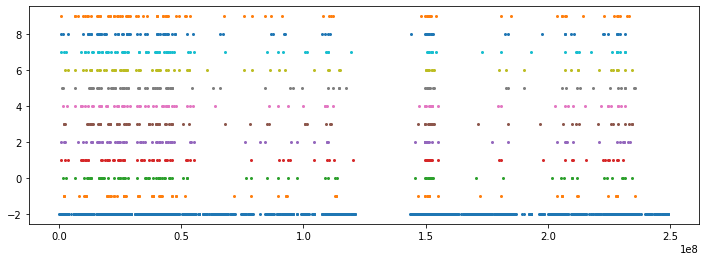

In [97]:
# temp_df = DF_GENE.loc[(DF_GENE['CHR']=='1') & DF_GENE['GENE'].isin(dic_gs[trait])]
# temp_df_full = DF_GENE.loc[(DF_GENE['CHR']=='1')]

# plt.figure(figsize=[12,4])
# plt.scatter(temp_df_full['START'], [-2]*temp_df_full.shape[0], s=4)
# plt.scatter(temp_df['START'], [-1]*temp_df.shape[0], s=4)
# for i_rep in range(n_rep):
#     temp_df_null = DF_GENE.loc[(DF_GENE['CHR']=='1') & DF_GENE['GENE'].isin(dic_gs['%s.loc_%d'%(trait,i_rep)])]
#     plt.scatter(temp_df_null['START'], [i_rep]*temp_df.shape[0], s=4)
# plt.show()

### Analysis

In [6]:
# FDR control 
for score in ['tms_facs', 'tms_facs_assump_check']:
    for trait in DIC_TRAIT_LIST[score]:
        print('{:^25s} {:^50s} {:^15s} {:^15s}'.format(
            score, trait, 
            'FDR<0.1=%d'%(dic_score[score]['%s.fdr'%trait]<0.1).sum(),
            'FDR<0.2=%d'%(dic_score[score]['%s.fdr'%trait]<0.1).sum(),
        ))
        dic_score['tms_facs']

        tms_facs                         PASS_IBD_deLange2017                  FDR<0.1=694     FDR<0.2=694  
        tms_facs                   PASS_Schizophrenia_Pardinas2018            FDR<0.1=1068    FDR<0.2=1068  
        tms_facs                 UKB_460K.biochemistry_Triglycerides           FDR<0.1=655     FDR<0.2=655  
        tms_facs                        UKB_460K.body_HEIGHTz                  FDR<0.1=695     FDR<0.2=695  
  tms_facs_assump_check                  PASS_IBD_deLange2017                  FDR<0.1=694     FDR<0.2=694  
  tms_facs_assump_check            PASS_Schizophrenia_Pardinas2018            FDR<0.1=1068    FDR<0.2=1068  
  tms_facs_assump_check          UKB_460K.biochemistry_Triglycerides           FDR<0.1=655     FDR<0.2=655  
  tms_facs_assump_check                 UKB_460K.body_HEIGHTz                  FDR<0.1=695     FDR<0.2=695  
  tms_facs_assump_check               PASS_IBD_deLange2017.loc_0                FDR<0.1=0       FDR<0.2=0   
  tms_facs_assump_c

In [10]:
score = 'tms_facs_assump_check'
q_list = 10**np.linspace(-3,0,30)

df_res = pd.DataFrame(index=q_list, columns=DIC_TRAIT_LIST[score], data=-1)
for trait in DIC_TRAIT_LIST[score]:
    df_res[trait] = np.quantile(dic_score[score]['%s.pval'%trait], q_list)

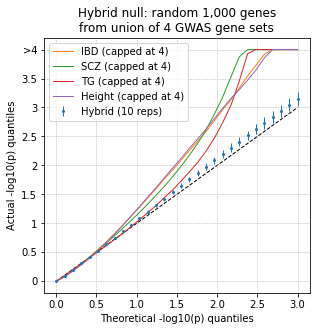

In [27]:
# Hybrid 
plt.figure(figsize=[4.5,4.7])

# Null
plot_list = [x for x in DIC_TRAIT_LIST[score] if 'hybrid' in x]
# for trait in plot_list:
#     v_x = -np.log10(df_res.index)
#     v_y = -np.log10(df_res[trait])
#     plt.plot(v_x, v_y, alpha=0.2, linewidth=1.5, color='C0')
    
v_mean = df_res[plot_list].mean(axis=1)
v_se = df_res[plot_list].std(axis=1) / np.sqrt(len(plot_list))
v_log_se = np.log10(v_mean+1.96*v_se) - np.log10(v_mean)
plt.errorbar(-np.log10(df_res.index), -np.log10(v_mean), yerr = v_log_se, 
             label='Hybrid (10 reps)', fmt='.', markersize=4, elinewidth=1, color='C0')

# GWAS 
for i,trait in enumerate(DIC_TRAIT_LIST['tms_facs']):
    v_x = -np.log10(df_res.index.values)
    v_y = -np.log10(df_res[trait].values).clip(min=-4)
    plt.plot(v_x, v_y, alpha=1, linewidth=1, color='C%d'%(i+1),
             label='%s (capped at 4)'%DF_TRAIT_INFO.loc[trait, 'Code'])

plt.plot([0, 3], [0, 3], linestyle='--', linewidth=1, color='k', zorder=0)
plt.xlabel('Theoretical -log10(p) quantiles')
plt.ylabel('Actual -log10(p) quantiles')
plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4],[0,0.5,1,1.5,2,2.5,3,3.5,'>4'])
plt.grid(linestyle='--', linewidth=0.5)
plt.title('Hybrid null: random 1,000 genes\nfrom union of 4 GWAS gene sets')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_PATH+'/other_null_hybrid.svg')
plt.show()

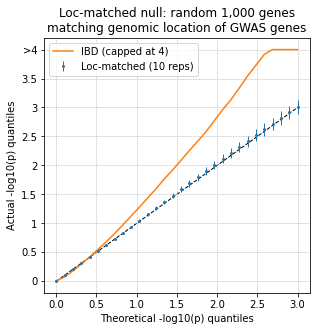

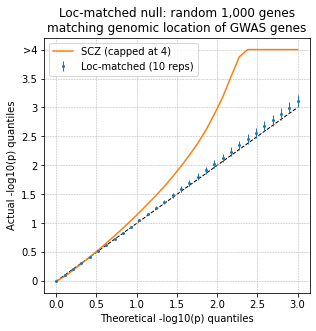

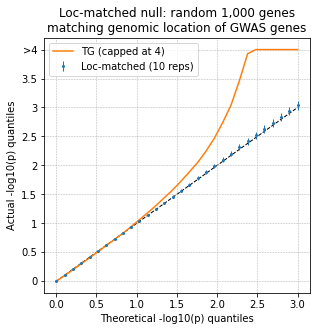

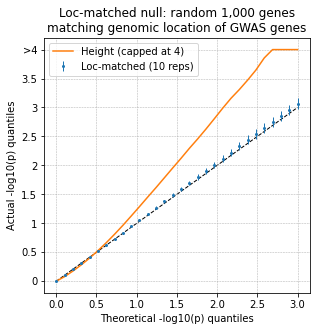

In [30]:
# Loc-matched null
for trait_ref in DIC_TRAIT_LIST['tms_facs']:
    
    plt.figure(figsize=[4.5,4.7])
    # Null
    plot_list = [x for x in DIC_TRAIT_LIST[score] if '%s.loc'%trait_ref in x]
#     for trait in plot_list:
#         v_x = -np.log10(df_res.index)
#         v_y = -np.log10(df_res[trait])
#         plt.plot(v_x, v_y, alpha=0.2, linewidth=1, color='C0')

    v_mean = df_res[plot_list].mean(axis=1)
    v_se = df_res[plot_list].std(axis=1) / np.sqrt(len(plot_list))
    v_log_se = np.log10(v_mean+1.96*v_se) - np.log10(v_mean)
    plt.errorbar(-np.log10(df_res.index), -np.log10(v_mean), yerr = v_log_se, 
                 label='Loc-matched (10 reps)', fmt='.', markersize=4, elinewidth=1, color='C0')

    # GWAS 
    v_x = -np.log10(df_res.index.values)
    v_y = -np.log10(df_res[trait_ref].values).clip(min=-4)
    plt.plot(v_x, v_y, alpha=1, linewidth=1.5, color='C1',
             label='%s (capped at 4)'%DF_TRAIT_INFO.loc[trait_ref, 'Code'])

    plt.plot([0, 3], [0, 3], linestyle='--', linewidth=1, color='k', zorder=0)
    plt.xlabel('Theoretical -log10(p) quantiles')
    plt.ylabel('Actual -log10(p) quantiles')
    plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4],[0,0.5,1,1.5,2,2.5,3,3.5,'>4'])
    plt.grid(linestyle='--', linewidth=0.5)
    plt.title('Loc-matched null: random 1,000 genes\nmatching genomic location of GWAS genes')
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/other_null_loc_match.%s.svg'%DF_TRAIT_INFO.loc[trait_ref, 'Code'])
    plt.show()

In [26]:
FIG_PATH

'/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_simu.rv1'